# Processing

In this example, we discuss different ways to process an event in Python. We compare several approaches to find the most efficient one.

Processing large amounts of data in Python can be as fast as in C++ if one uses Numpy and Numba effectively, and if data structures of the underlying C++ library can be directly access as Numpy array views. Unfortunately, the internal design of the C++ HepMC3 library does not allow us to do that. Therefore, processing a GenEvent in Python cannot be as fast as in C++.

pyhepmc still offers limited access to the most important properties of particles and vertices via Numpy arrays. These arrays can be used to speed up the processing of large events.

We demonstrate three methods to compute the energy sum in final state protons using different APIs. We apply these methods on a comparably small event with 23 particles and a large event with 2661 particles.

In [1]:
import pyhepmc as hp
from particle import literals as lp
import numpy as np
from IPython.display import display

with hp.open("../../tests/sibyll21.dat") as f:
    for small_event in f:
        pass

with hp.open("../../tests/eposlhc_large.dat") as f:
    for large_event in f:
        pass

print("small event", len(small_event.particles), "particles")
print("large event", len(large_event.particles), "particles")

small event 23 particles
large event 2661 particles


**Method 1**

In our first method, we use the normal event API. We need to loop over particles, select those which are protons and final state (status == 1), and sum their energies.

In [2]:
def sum_energy_of_protons_1(event):
    esum = 0.0
    for p in event.particles:
        if abs(p.pid) != lp.proton.pdgid:
            continue
        if p.status != 1:
            continue
        esum += p.momentum.e
    return esum

sum_energy_of_protons_1(large_event)

8546.505081295967

**Method 2**

HepMC3 supports an alternative in-memory representation to the GenEvent, the GenEventData object. This object allows us to view its memory as a Numpy array. It can be used also to manipulate the internal state. The number of particles cannot be changed with this API, since the GenEventData object is not designed to support safe and consistent modification of GenEvent data.

We allocate one GenEventData object, write the data from the GenEvent into it, and use views in form of Numpy arrays into its memory to select and sum the particles of interest using fast Numpy functions.

In [3]:
event_data = hp.GenEventData()


def sum_energy_of_protons_2(event):
    event.write_data(event_data)
    p = event_data.particles
    ma = (np.abs(p["pid"]) == lp.proton.pdgid)
    ma &= p["status"] == 1
    e = p["e"]
    return np.sum(e[ma])


sum_energy_of_protons_2(large_event)

8546.505081295967

**Method 3**

The caveat of the previous method is that we have to convert the GenEvent into a GenEventData object, which is not cheap. An additional interface was added to the GenEvent for read-only access to the most important vertex and particles properties in form of Numpy arrays. These arrays cannot be used to manipulate the GenEvent.

In [4]:
def sum_energy_of_protons_3(event):
    ma = np.abs(event.np_particles_pdg_id()) == lp.proton.pdgid
    ma &= event.np_particles_status() == 1
    e = event.np_particles_momentum_e()
    return np.sum(e[ma])

sum_energy_of_protons_3(large_event)

8546.505081295967

To provide a baseline of the fastest possible speed, the function `sum_energy_of_protons` was also implemented in C++.

In [5]:
from pyhepmc._core import _sum_energy_of_protons as sum_energy_of_protons_0

Let's benchmark all methods and compare their speed.

In [6]:
t0a = %timeit -n 10 -o sum_energy_of_protons_0(small_event)
t0b = %timeit -n 10 -o sum_energy_of_protons_0(large_event)

t1a = %timeit -n 10 -o sum_energy_of_protons_1(small_event)
t1b = %timeit -n 10 -o sum_energy_of_protons_1(large_event)

t2a = %timeit -n 10 -o sum_energy_of_protons_2(small_event)
t2b = %timeit -n 10 -o sum_energy_of_protons_2(large_event)

t3a = %timeit -n 10 -o sum_energy_of_protons_3(small_event)
t3b = %timeit -n 10 -o sum_energy_of_protons_3(large_event)

235 ns ± 168 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
3.72 µs ± 616 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)
14.1 µs ± 1.12 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.25 ms ± 26.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
The slowest run took 7.68 times longer than the fastest. This could mean that an intermediate result is being cached.
30.5 µs ± 33.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
408 µs ± 198 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
5.95 µs ± 1.08 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
17.7 µs ± 883 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)


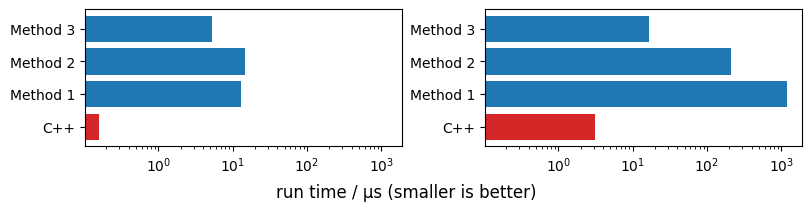

In [7]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(8, 2), sharex=True, constrained_layout=True)
labels = ["C++", "Method 1", "Method 2", "Method 3"]
colors = ["C3"] + ["C0"]*3
ax[0].barh(labels, [t.best * 1e6 for t in [t0a, t1a, t2a, t3a]], color=colors)
ax[1].barh(labels, [t.best * 1e6 for t in [t0b, t1b, t2b, t3b]], color=colors)
fig.supxlabel("run time / µs (smaller is better)")
plt.semilogx();

In [8]:
t3a.best / t0a.best, t3b.best / t0b.best, t1a.best / t3a.best, t1b.best / t3b.best, 

(32.89876773176673, 5.34263048729356, 2.4263710227111877, 71.82603773768358)

Method 3 is the fastest Python method for read-only processing of both small and large events. In case of large (small) events, it is 70x (2x) faster than the straight-forward API.

With the fastest method, processing in Python is a factor 6 to 36 slower than doing the work in C++.